In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

reduce_mem_usage 函数通过调整数据类型，帮助我们减少数据在内存中占用的空间

In [2]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() 
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() 
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
sample_feature = reduce_mem_usage(pd.read_csv('C:/Users/oy/data_for_tree.csv'))

Memory usage of dataframe is 62099624.00 MB
Memory usage after optimization is: 16520255.00 MB
Decreased by 73.4%


In [4]:
continuous_feature_names = [x for x in sample_feature.columns if x not in ['price','brand','model','brand']]

In [5]:
sample_feature = sample_feature.dropna().replace('-', 0).reset_index(drop=True)
sample_feature['notRepairedDamage'] = sample_feature['notRepairedDamage'].astype(np.float32)
train = sample_feature[continuous_feature_names + ['price']]

train_X = train[continuous_feature_names]
train_y = train['price']

In [6]:
from sklearn.linear_model import LinearRegression

In [7]:
model = LinearRegression(normalize=True)

In [8]:
model = model.fit(train_X, train_y)

查看训练的线性回归模型的截距（intercept）与权重(coef)

In [9]:
'intercept:'+ str(model.intercept_)

sorted(dict(zip(continuous_feature_names, model.coef_)).items(), key=lambda x:x[1], reverse=True)

[('v_6', 3367064.341641923),
 ('v_8', 700675.5609399091),
 ('v_9', 170630.27723222884),
 ('v_7', 32322.66193204455),
 ('v_12', 20473.67079693435),
 ('v_3', 17868.07954147758),
 ('v_11', 11474.938996710885),
 ('v_13', 11261.764560006319),
 ('v_10', 2683.9200905641287),
 ('gearbox', 881.8225039247452),
 ('fuelType', 363.90425072172997),
 ('bodyType', 189.60271012075253),
 ('city', 44.949751205216515),
 ('power', 28.553901616756082),
 ('brand_price_median', 0.510372813407879),
 ('brand_price_std', 0.45036347092632295),
 ('brand_amount', 0.14881120395065614),
 ('brand_price_max', 0.003191018670316297),
 ('SaleID', 5.3559899198625126e-05),
 ('seller', -5.826179403811693e-06),
 ('offerType', -1.5477417036890984e-05),
 ('train', -1.7476966604590416e-05),
 ('brand_price_sum', -2.1750068681876325e-05),
 ('name', -0.00029800127130529485),
 ('used_time', -0.0025158943328600645),
 ('brand_price_average', -0.4049048451011321),
 ('brand_price_min', -2.2467753486897446),
 ('power_bin', -34.4206441172

In [10]:
from matplotlib import pyplot as plt

In [11]:
subsample_index = np.random.randint(low=0, high=len(train_y), size=50)

绘制特征v_9的值与标签的散点图，图片发现模型的预测结果（蓝色点）与真实标签（黑色点）的分布差异较大，且部分预测值出现了小于0的情况，说明我们的模型存在一些问题

The predicted price is obvious different from true price


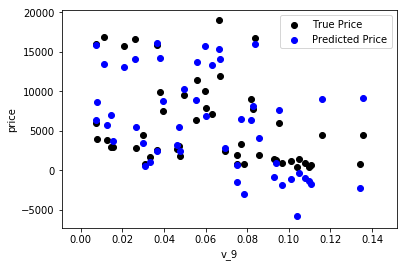

In [12]:
plt.scatter(train_X['v_9'][subsample_index], train_y[subsample_index], color='black')
plt.scatter(train_X['v_9'][subsample_index], model.predict(train_X.loc[subsample_index]), color='blue')
plt.xlabel('v_9')
plt.ylabel('price')
plt.legend(['True Price','Predicted Price'],loc='upper right')
print('The predicted price is obvious different from true price')
plt.show()

It is clear to see the price shows a typical exponential distribution


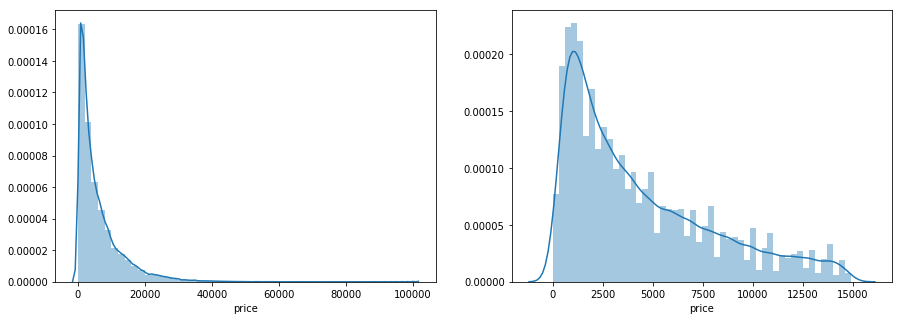

In [13]:
import seaborn as sns
print('It is clear to see the price shows a typical exponential distribution')
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(train_y)
plt.subplot(1,2,2)
sns.distplot(train_y[train_y < np.quantile(train_y, 0.9)])

在这里我们对标签进行了 $log(x+1)$ 变换，使标签贴近于正态分布

In [14]:
train_y_ln = np.log(train_y + 1)

The transformed price seems like normal distribution


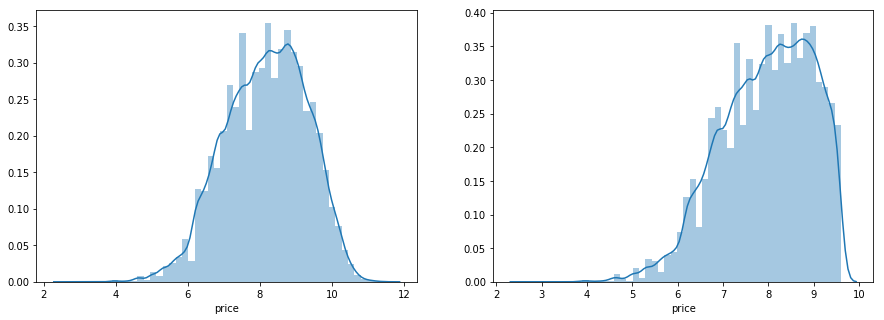

In [15]:
import seaborn as sns
print('The transformed price seems like normal distribution')
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(train_y_ln)
plt.subplot(1,2,2)
sns.distplot(train_y_ln[train_y_ln < np.quantile(train_y_ln, 0.9)])

In [16]:
model = model.fit(train_X, train_y_ln)

print('intercept:'+ str(model.intercept_))
sorted(dict(zip(continuous_feature_names, model.coef_)).items(), key=lambda x:x[1], reverse=True)

intercept:18.750749465537744


[('v_9', 8.052409900567463),
 ('v_5', 5.76423659665188),
 ('v_12', 1.6182081236823307),
 ('v_1', 1.479831058298351),
 ('v_11', 1.166901656362176),
 ('v_13', 0.9404711296039686),
 ('v_7', 0.7137273083563592),
 ('v_3', 0.6837875771100868),
 ('v_0', 0.008500518010124166),
 ('power_bin', 0.008497969302895097),
 ('gearbox', 0.007922377278328277),
 ('fuelType', 0.0066847697068315275),
 ('bodyType', 0.004523520092703293),
 ('power', 0.0007161894205356613),
 ('brand_price_min', 3.3343511147496795e-05),
 ('brand_amount', 2.8978797042773418e-06),
 ('brand_price_median', 1.25711728730482e-06),
 ('brand_price_std', 6.65917636344991e-07),
 ('brand_price_max', 6.194956307516141e-07),
 ('brand_price_average', 5.999345965017997e-07),
 ('SaleID', 2.1194170039653565e-08),
 ('seller', 1.9016610508515441e-10),
 ('train', 3.3999469906120794e-11),
 ('offerType', -1.5589307622576598e-11),
 ('brand_price_sum', -1.5126504215920728e-10),
 ('name', -7.015512588904276e-08),
 ('used_time', -4.122479372350322e-06),

再次进行可视化，发现预测结果与真实值较为接近，且未出现异常状况

The predicted price seems normal after np.log transforming


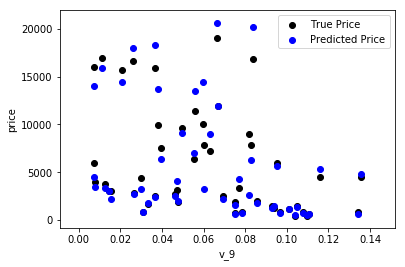

In [17]:
plt.scatter(train_X['v_9'][subsample_index], train_y[subsample_index], color='black')
plt.scatter(train_X['v_9'][subsample_index], np.exp(model.predict(train_X.loc[subsample_index])), color='blue')
plt.xlabel('v_9')
plt.ylabel('price')
plt.legend(['True Price','Predicted Price'],loc='upper right')
print('The predicted price seems normal after np.log transforming')
plt.show()

#### 五折交叉验证

> 在使用训练集对参数进行训练的时候，经常会发现人们通常会将一整个训练集分为三个部分（比如mnist手写训练集）。一般分为：训练集（train_set），评估集（valid_set），测试集（test_set）这三个部分。这其实是为了保证训练效果而特意设置的。其中测试集很好理解，其实就是完全不参与训练的数据，仅仅用来观测测试效果的数据。而训练集和评估集则牵涉到下面的知识了。

>因为在实际的训练中，训练的结果对于训练集的拟合程度通常还是挺好的（初始条件敏感），但是对于训练集之外的数据的拟合程度通常就不那么令人满意了。因此我们通常并不会把所有的数据集都拿来训练，而是分出一部分来（这一部分不参加训练）对训练集生成的参数进行测试，相对客观的判断这些参数对训练集之外的数据的符合程度。这种思想就称为交叉验证（Cross Validation）

In [18]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error,  make_scorer

In [19]:
def log_transfer(func):
    def wrapper(y, yhat):
        result = func(np.log(y), np.nan_to_num(np.log(yhat)))
        return result
    return wrapper

In [20]:
scores = cross_val_score(model, X=train_X, y=train_y, verbose=1, cv = 5, scoring=make_scorer(log_transfer(mean_absolute_error)))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.8s finished


In [21]:
print('AVG:', np.mean(scores))

AVG: 1.3658023920313949


In [22]:
scores = cross_val_score(model, X=train_X, y=train_y_ln, verbose=1, cv = 5, scoring=make_scorer(mean_absolute_error))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.9s finished


In [23]:
print('AVG:', np.mean(scores))

AVG: 0.19325301837047398


In [24]:
scores = pd.DataFrame(scores.reshape(1,-1))
scores.columns = ['cv' + str(x) for x in range(1, 6)]
scores.index = ['MAE']
scores

,cv1,cv2,cv3,cv4,cv5
MAE,0.190792,0.193758,0.194132,0.191825,0.195758


#### 模拟真实业务情况

但在事实上，由于我们并不具有预知未来的能力，五折交叉验证在某些与时间相关的数据集上反而反映了不真实的情况。通过2018年的二手车价格预测2017年的二手车价格，这显然是不合理的，因此我们还可以采用时间顺序对数据集进行分隔。在本例中，我们选用靠前时间的4/5样本当作训练集，靠后时间的1/5当作验证集，最终结果与五折交叉验证差距不大

In [25]:
import datetime

In [26]:
sample_feature = sample_feature.reset_index(drop=True)

In [27]:
split_point = len(sample_feature) // 5 * 4

In [28]:
train = sample_feature.loc[:split_point].dropna()
val = sample_feature.loc[split_point:].dropna()

train_X = train[continuous_feature_names]
train_y_ln = np.log(train['price'] + 1)
val_X = val[continuous_feature_names]
val_y_ln = np.log(val['price'] + 1)

In [29]:
model = model.fit(train_X, train_y_ln)

In [30]:
mean_absolute_error(val_y_ln, model.predict(val_X))

0.19577667270301036

In [31]:
from sklearn.model_selection import learning_curve, validation_curve

In [32]:
? learning_curve

In [33]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,n_jobs=1, train_size=np.linspace(.1, 1.0, 5 )):  
    plt.figure()  
    plt.title(title)  
    if ylim is not None:  
        plt.ylim(*ylim)  
    plt.xlabel('Training example')  
    plt.ylabel('score')  
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_size, scoring = make_scorer(mean_absolute_error))  
    train_scores_mean = np.mean(train_scores, axis=1)  
    train_scores_std = np.std(train_scores, axis=1)  
    test_scores_mean = np.mean(test_scores, axis=1)  
    test_scores_std = np.std(test_scores, axis=1)  
    plt.grid()#区域  
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,  
                     train_scores_mean + train_scores_std, alpha=0.1,  
                     color="r")  
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,  
                     test_scores_mean + test_scores_std, alpha=0.1,  
                     color="g")  
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r',  
             label="Training score")  
    plt.plot(train_sizes, test_scores_mean,'o-',color="g",  
             label="Cross-validation score")  
    plt.legend(loc="best")  
    return plt  

<module 'matplotlib.pyplot' from 'D:\\Anaconda35\\Anaconda333\\lib\\site-packages\\matplotlib\\pyplot.py'>

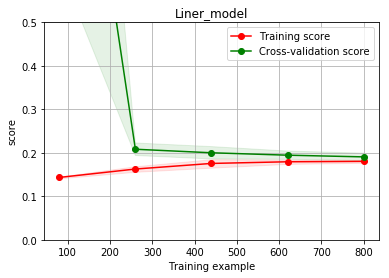

In [34]:
plot_learning_curve(LinearRegression(), 'Liner_model', train_X[:1000], train_y_ln[:1000], ylim=(0.0, 0.5), cv=5, n_jobs=1)  

In [35]:
train = sample_feature[continuous_feature_names + ['price']].dropna()

train_X = train[continuous_feature_names]
train_y = train['price']
train_y_ln = np.log(train_y + 1)

In [36]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

In [37]:
models = [LinearRegression(),
          Ridge(),
          Lasso()]

In [38]:
result = dict()
for model in models:
    model_name = str(model).split('(')[0]
    scores = cross_val_score(model, X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error))
    result[model_name] = scores
    print(model_name + ' is finished')

LinearRegression is finished
Ridge is finished
Lasso is finished


对三种方法的效果对比

In [39]:
result = pd.DataFrame(result)
result.index = ['cv' + str(x) for x in range(1, 6)]
result

,LinearRegression,Ridge,Lasso
cv1,0.190792,0.194832,0.383899
cv2,0.193758,0.197632,0.381894
cv3,0.194132,0.198123,0.384090
cv4,0.191825,0.195670,0.380526
cv5,0.195758,0.199676,0.383611


intercept:18.750373179463164


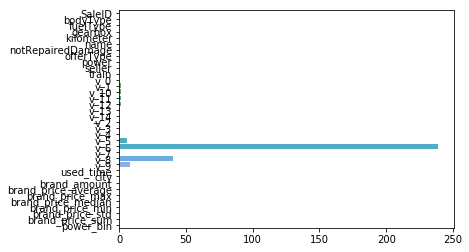

In [40]:
model = LinearRegression().fit(train_X, train_y_ln)
print('intercept:'+ str(model.intercept_))
sns.barplot(abs(model.coef_), continuous_feature_names)

L2正则化在拟合过程中通常都倾向于让权值尽可能小，最后构造一个所有参数都比较小的模型。因为一般认为参数值小的模型比较简单，能适应不同的数据集，也在一定程度上避免了过拟合现象。可以设想一下对于一个线性回归方程，若参数很大，那么只要数据偏移一点点，就会对结果造成很大的影响；但如果参数足够小，数据偏移得多一点也不会对结果造成什么影响，专业一点的说法是『抗扰动能力强』

intercept:4.671709787241662


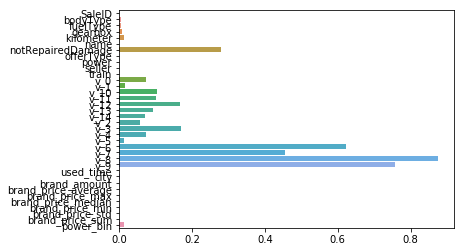

In [41]:
model = Ridge().fit(train_X, train_y_ln)
print('intercept:'+ str(model.intercept_))
sns.barplot(abs(model.coef_), continuous_feature_names)

L1正则化有助于生成一个稀疏权值矩阵，进而可以用于特征选择。如下图，我们发现power与userd_time特征非常重要。

intercept:8.672184761637329


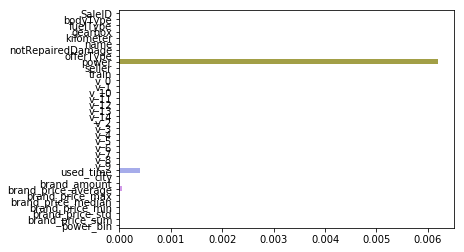

In [42]:
model = Lasso().fit(train_X, train_y_ln)
print('intercept:'+ str(model.intercept_))
sns.barplot(abs(model.coef_), continuous_feature_names)

除此之外，决策树通过信息熵或GINI指数选择分裂节点时，优先选择的分裂特征也更加重要，这同样是一种特征选择的方法。XGBoost与LightGBM模型中的model_importance指标正是基于此计算的

In [48]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from xgboost.sklearn import XGBRegressor
from lightgbm.sklearn import LGBMRegressor

In [49]:
models = [LinearRegression(),
          DecisionTreeRegressor(),
          RandomForestRegressor(),
          GradientBoostingRegressor(),
          MLPRegressor(solver='lbfgs', max_iter=100), 
          XGBRegressor(n_estimators = 100, objective='reg:squarederror'), 
          LGBMRegressor(n_estimators = 100)]

In [50]:
result = dict()
for model in models:
    model_name = str(model).split('(')[0]
    scores = cross_val_score(model, X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error))
    result[model_name] = scores
    print(model_name + ' is finished')

LinearRegression is finished

DecisionTreeRegressor is finished

RandomForestRegressor is finished

GradientBoostingRegressor is finished

MLPRegressor is finished

XGBRegressor is finished

LGBMRegressor is finished


In [51]:
result = pd.DataFrame(result)
result.index = ['cv' + str(x) for x in range(1, 6)]
result

,LinearRegression,DecisionTreeRegressor,RandomForestRegressor,GradientBoostingRegressor,MLPRegressor,XGBRegressor,LGBMRegressor
cv1,0.191642,0.184566,0.136266,0.168626,124.299426,0.168698,0.141159
cv2,0.194986,0.187029,0.139693,0.171905,257.886236,0.172258,0.143363
cv3,0.192737,0.184839,0.136871,0.169553,236.829589,0.168604,0.142137
cv4,0.195329,0.182605,0.138689,0.172299,130.197264,0.172474,0.143461
cv5,0.194450,0.186626,0.137420,0.171206,268.090236,0.170898,0.141921


可以看到随机森林模型在每一个fold中均取得了更好的效果

####  模型调参

In [52]:
## LGB的参数集合：

objective = ['regression', 'regression_l1', 'mape', 'huber', 'fair']

num_leaves = [3,5,10,15,20,40, 55]
max_depth = [3,5,10,15,0,40, 55]
bagging_fraction = []
feature_fraction = []
drop_rate = []

####  贪心调参

In [ ]:
"""
所谓贪心选择性质是指所求问题的整体最优解可以通过一系列局部最优的选择，换句话说，当考虑做何种选择的时候，我们只考虑对当前问题最佳的选择而不考虑子问题的结果。这是贪心算法可行的第一个基本要素。贪心算法以迭代的方式作出相继的贪心选择，每作一次贪心选择就将所求问题简化为规模更小的子问题。对于一个具体问题，要确定它是否具有贪心选择性质，必须证明每一步所作的贪心选择最终导致问题的整体最优解。
当一个问题的最优解包含其子问题的最优解时，称此问题具有最优子结构性质。问题的最优子结构性质是该问题可用贪心算法求解的关键特征。
"""

In [53]:
best_obj = dict()
for obj in objective:
    model = LGBMRegressor(objective=obj)
    score = np.mean(cross_val_score(model, X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error)))
    best_obj[obj] = score
    
best_leaves = dict()
for leaves in num_leaves:
    model = LGBMRegressor(objective=min(best_obj.items(), key=lambda x:x[1])[0], num_leaves=leaves)
    score = np.mean(cross_val_score(model, X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error)))
    best_leaves[leaves] = score
    
best_depth = dict()
for depth in max_depth:
    model = LGBMRegressor(objective=min(best_obj.items(), key=lambda x:x[1])[0],
                          num_leaves=min(best_leaves.items(), key=lambda x:x[1])[0],
                          max_depth=depth)
    score = np.mean(cross_val_score(model, X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error)))
    best_depth[depth] = score

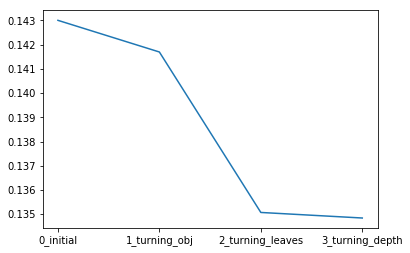

In [54]:
sns.lineplot(x=['0_initial','1_turning_obj','2_turning_leaves','3_turning_depth'], y=[0.143 ,min(best_obj.values()), min(best_leaves.values()), min(best_depth.values())])

#### Grid Search 调参

In [ ]:
"""
一种调参的方法，当你算法模型效果不是很好时，可以通过该方法来调整参数，通过循环遍历，尝试每一种参数组合，返回最好的得分值的参数组合
比如支持向量机中的参数 C 和 gamma ，当我们不知道哪个参数效果更好时，可以通过该方法来选择参数，我们把C 和gamma 的选择范围定位[0.001,0.01,0.1,1,10,100]
每个参数都能组合在一起，循环过程就像是在网格中遍历，所以叫网格搜索.
"""

In [55]:
from sklearn.model_selection import GridSearchCV

In [56]:
parameters = {'objective': objective , 'num_leaves': num_leaves, 'max_depth': max_depth}
model = LGBMRegressor()
clf = GridSearchCV(model, parameters, cv=5)
clf = clf.fit(train_X, train_y)

In [57]:
clf.best_params_

{'max_depth': 15, 'num_leaves': 55, 'objective': 'regression'}

In [58]:
model = LGBMRegressor(objective='regression',
                          num_leaves=55,
                          max_depth=15)

In [59]:
np.mean(cross_val_score(model, X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error)))

0.13626164479243302

#### 贝叶斯调参

In [ ]:
"""
贝叶斯优化通过基于目标函数的过去评估结果建立替代函数（概率模型），来找到最小化目标函数的值。贝叶斯方法与随机或网格搜索的不同之处在于，它在尝试下一组超参数时，会参考之前的评估结果，因此可以省去很多无用功。

超参数的评估代价很大，因为它要求使用待评估的超参数训练一遍模型，而许多深度学习模型动则几个小时几天才能完成训练，并评估模型，因此耗费巨大。贝叶斯调参发使用不断更新的概率模型，通过推断过去的结果来“集中”有希望的超参数。
"""

In [60]:
from bayes_opt import BayesianOptimization

In [61]:
def rf_cv(num_leaves, max_depth, subsample, min_child_samples):
    val = cross_val_score(
        LGBMRegressor(objective = 'regression_l1',
            num_leaves=int(num_leaves),
            max_depth=int(max_depth),
            subsample = subsample,
            min_child_samples = int(min_child_samples)
        ),
        X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error)
    ).mean()
    return 1 - val

In [62]:
rf_bo = BayesianOptimization(
    rf_cv,
    {
    'num_leaves': (2, 100),
    'max_depth': (2, 100),
    'subsample': (0.1, 1),
    'min_child_samples' : (2, 100)
    }
)

In [63]:
rf_bo.maximize()

|   iter    |  target   | max_depth | min_ch... | num_le... | subsample |

-------------------------------------------------------------------------

|  1        |  0.8649   |  89.57    |  47.3     |  55.13    |  0.1792   |

|  2        |  0.8477   |  99.86    |  60.91    |  15.35    |  0.4716   |

|  3        |  0.8698   |  81.74    |  83.32    |  92.59    |  0.9559   |

|  4        |  0.8627   |  90.2     |  8.754    |  43.34    |  0.7772   |

|  5        |  0.8115   |  10.07    |  86.15    |  4.109    |  0.3416   |

|  6        |  0.8701   |  99.15    |  9.158    |  99.47    |  0.494    |

|  7        |  0.806    |  2.166    |  2.416    |  97.7     |  0.224    |

|  8        |  0.8701   |  98.57    |  97.67    |  99.87    |  0.3703   |

|  9        |  0.8703   |  99.87    |  43.03    |  99.72    |  0.9749   |

|  10       |  0.869    |  10.31    |  99.63    |  99.34    |  0.2517   |

|  11       |  0.8703   |  52.27    |  99.56    |  98.97    |  0.9641   |

|  12       |  0.8669   |

In [64]:
1 - rf_bo.max['target']

0.1296693644053145

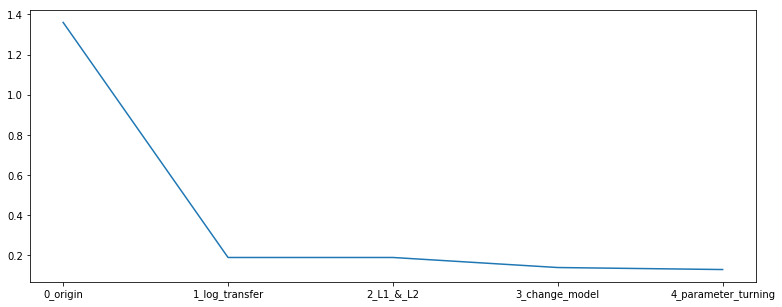

In [70]:
plt.figure(figsize=(13,5))
sns.lineplot(x=['0_origin','1_log_transfer','2_L1_&_L2','3_change_model','4_parameter_turning'], y=[1.36 ,0.19, 0.19, 0.14, 0.13])